# SimPEG(emg3d)

Use either via

- `conda env create -f environment-simpeg-emg3d.yml`

(creates env `simpeg-emg3d`), or manually by installing

- SimPEG: `pip install git+https://github.com/simpeg/simpeg@refs/pull/1515/head`
- emg3d: `pip install git+https://github.com/emsig/emg3d@simpeg`
- Additionally: `xarray`, `matplotlib`, `ipympl`

## TODOs:
- Clean-up the two PR's
- Change this example to create survey and simulation with emg3d, and use simpeg only for the inversion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import simpeg
import simpeg.electromagnetics.frequency_domain as FDEM

In [2]:
%matplotlib widget

## Create a model

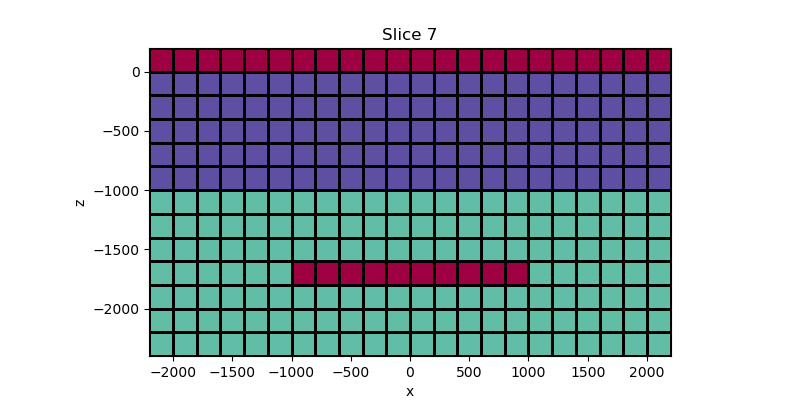

In [3]:
hx = np.ones(22)*200.0
hy = np.ones(14)*200.0
hz = np.ones(13)*200.0
mesh = emg3d.TensorMesh([hx, hy, hz], origin=[-2200, -1400, -2400])

inds_air = mesh.cell_centers[:,2] > 0.
inds_seafloor = mesh.cell_centers[:,2] < -1000.
inds_hydrocarbon = (
    np.logical_and(mesh.cell_centers[:,2] <- 1500, mesh.cell_centers[:,2] > -1900) & 
    np.logical_and(mesh.cell_centers[:,0] >- 1000, mesh.cell_centers[:,0] < 1000) &
    np.logical_and(mesh.cell_centers[:,1] >- 1000, mesh.cell_centers[:,1] < 1000)
)

sigma = np.ones(mesh.n_cells) * 1./0.33
sigma[inds_air] = 1./1e8
sigma[inds_seafloor] = 1./1.
sigma[inds_hydrocarbon] = 1./100

fig, ax = plt.subplots(1,1, figsize=(8, 4))
mesh.plot_slice(
    1./sigma, grid=True, normal='Y', ax=ax,
    pcolor_opts={'cmap': 'Spectral_r', 'norm': LogNorm(vmin=0.33, vmax=100)}, 
)
ax.set_aspect(1)

In [4]:
inds_active = mesh.cell_centers[:, 2] < -1000.

## Create a survey

In [5]:
rec_x = np.linspace(-1900, 1900, 20)
xyz_rx = simpeg.utils.ndgrid(rec_x, 0.0, -1000)
src_x = np.r_[-1900, -1300, -700, -100, 500, 1100, 1700]
xyz_src = simpeg.utils.ndgrid(src_x, -100, -900)

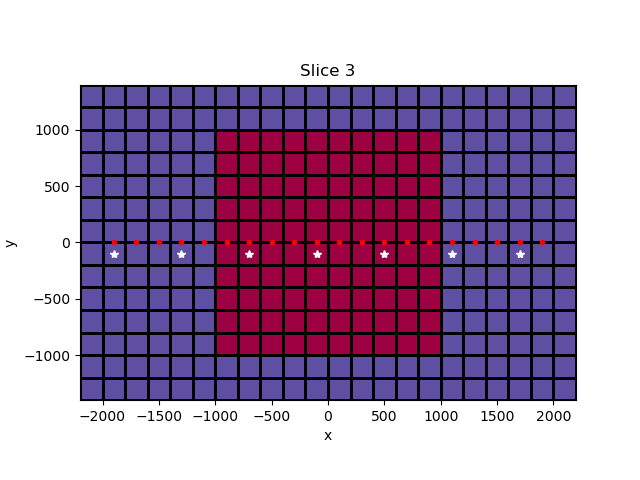

In [6]:
mesh.plot_slice(
    1./sigma, grid=True, normal='Z', ind=3,
    pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=1, vmax=100)}, 
)
plt.plot(xyz_rx[:,0], xyz_rx[:,1], 'r.')
plt.plot(xyz_src[:,0], xyz_src[:,1], 'w*')
plt.gca().set_aspect(1)

In [7]:
frequency = 2.0
rx_list = [
    FDEM.receivers.PointElectricField(
        orientation='x', component="complex", locations=xyz_rx),
]
src_list = []
for ii in range(xyz_src.shape[0]):
    src = FDEM.sources.ElectricDipole(rx_list, location=xyz_src[ii,:], frequency=frequency, azimuth=0, elevation=0)
    src_list.append(src)
survey = FDEM.Survey(src_list)

## Create simulation

In [8]:
active_map = simpeg.maps.InjectActiveCells(mesh, inds_active, sigma[~inds_active])
nP = int(inds_active.sum())
conductivity_map = active_map * simpeg.maps.ExpMap(nP=nP)
# conductivity_map = maps.IdentityMap(mesh)

In [9]:
# Define the Simulation
simulation = emg3d.inversion.simpeg.FDEMSimulation(
        mesh,
        survey=survey,
        sigmaMap=conductivity_map,
        verbose=False,
        simulation_opts={
            'max_workers': 6, 
            'gridding': 'single',
            'model': emg3d.Model(mesh, sigma, mapping='Conductivity'),
            'gridding_opts': {
                'seasurface': 0,
                'center': (0, 0, -1000),
                'vector': (mesh.nodes_x[1:-1], mesh.nodes_y[1:-1], mesh.nodes_z[2:-5]),
                'domain': ([-2000, 2000], [-1200, 1200], [-2000, -1000]),
                'min_width_limits': (200, 400, 100),
                'max_buffer': 20000,
                'lambda_from_center': True,
            },
        },
)

m_true =  np.log(sigma[inds_active])
# m_true =  np.ones(mesh.nC)
m0 =  np.ones(inds_active.sum()) * np.log(1.)

m2 = simulation.emg3d_sim.get_model('TxED-1', 'f-1')
m2.grid

TensorMesh: 30,720 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40    -20,364.34     20,364.34    200.00  5,342.01    1.39
   y     32    -20,093.54     20,093.54    200.00  5,539.48    1.39
   z     24     -3,984.95     19,437.30    200.00  5,743.49    1.40

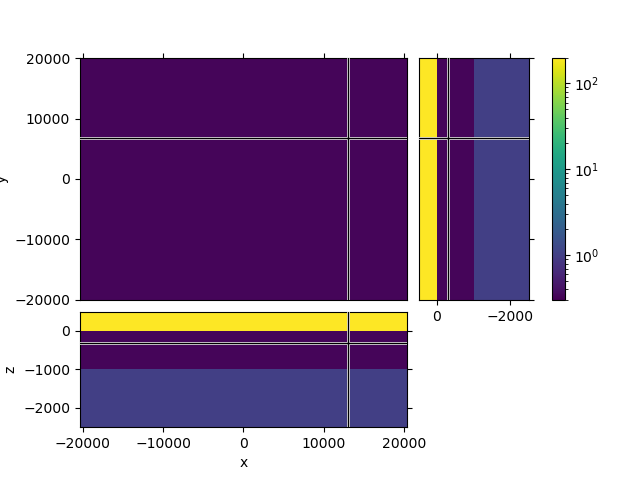

In [10]:
m2.grid.plot_3d_slicer(1/m2.property_x, xslice=12000, yslice=7000,
                       zlim=[-2500, 500],
                       pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=200)})

In [11]:
f = simulation.fields(m_true)
d_true = simulation.dpred(m_true, f=f)

In [12]:
d_0 = simulation.dpred(m0)

In [13]:
relative_error = 0.01
noise_floor = 1e-14
standard_deviation = np.sqrt(abs(relative_error*d_true)**2 + (noise_floor)**2)

In [14]:
residual = (d_true - d_0)/standard_deviation

In [15]:
np.vdot(residual, residual).real

56599.91825247498

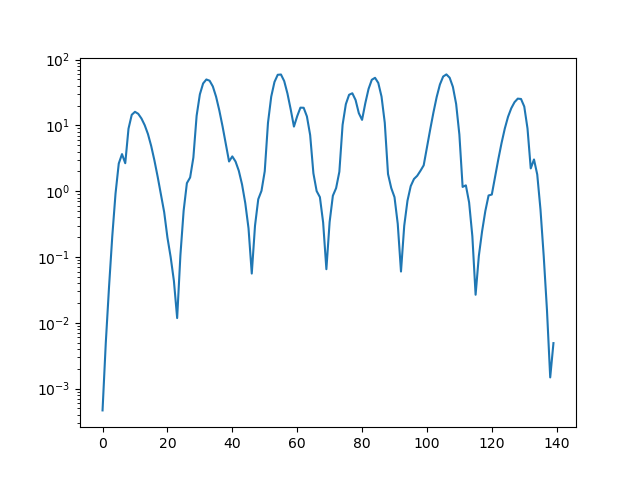

In [16]:
plt.figure()
plt.semilogy(abs(residual), label='dobs')
# plt.semilogy(standard_deviation,label='std')

(array([ 5.,  9., 19., 19., 23., 10., 23., 12., 13.,  7.]),
 array([-14.35633959, -13.72326463, -13.09018967, -12.45711471,
        -11.82403975, -11.19096479, -10.55788983,  -9.92481487,
         -9.29173991,  -8.65866495,  -8.02558999]),
 <BarContainer object of 10 artists>)

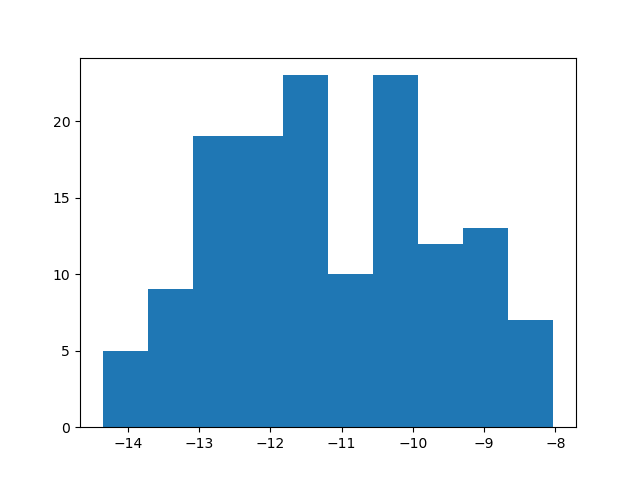

In [17]:
plt.figure()
plt.hist(np.log10(abs(d_true)))

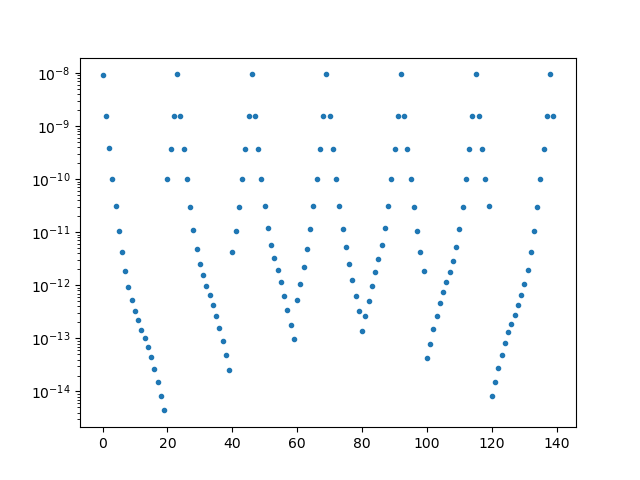

In [18]:
plt.figure()
plt.semilogy(abs(d_true), '.', label='pred')

In [19]:
em_data = simpeg.data.ComplexData(survey, dobs=d_true, standard_deviation=standard_deviation)
dmis = simpeg.data_misfit.L2DataMisfit(data=em_data, simulation=simulation)

In [20]:
adjoint_tol = 1e-10
def test_misfit():
    passed = simpeg.tests.check_derivative(
        lambda m: (simulation.dpred(m), lambda mx: simulation.Jvec(m0, mx, f=f)),
        m0,
        plotIt=False,
        num=3,
    )

def test_adjoint():
    # Adjoint Test
    f = simulation.fields(m=m0)
    # u = np.random.rand(.mesh.nC * .survey.nSrc)
    v = np.random.rand(inds_active.sum())
#     v = np.random.rand(mesh.nC)
    w = np.random.rand(simulation.survey.nD)
    wtJv = np.vdot(w, simulation.Jvec(m0, v, f=f)).real
    vtJtw = np.vdot(v, simulation.Jtvec(m0, w, f=f))
    passed = np.abs(wtJv - vtJtw) < adjoint_tol
    print("Adjoint Test", np.abs(wtJv - vtJtw), passed)
    print(wtJv, vtJtw)
    
def test_dataObj():
    passed = simpeg.tests.check_derivative(
        lambda m: [dmis(m), dmis.deriv(m)], m0, plotIt=False, num=2
    )    

In [21]:
test_dataObj()

==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.068e+03     2.075e+03      nan
 1   1.00e-02    1.929e+01     2.001e+01      2.016
========================= PASS! =========================
You are awesome.



In [22]:
test_misfit()

==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.778e-10     3.964e-11      nan
 1   1.00e-02    2.634e-11     3.893e-13      2.008
 2   1.00e-03    2.621e-12     3.886e-15      2.001
========================= PASS! =========================
Testing is important.



In [23]:
test_adjoint()

Adjoint Test 2.837125007466004e-17 True
1.7430375254683516e-09 1.7430374970971015e-09


In [24]:
%%time
# Define the regularization (model objective function)
reg = simpeg.regularization.WeightedLeastSquares(
    mesh,
    active_cells=inds_active,
    reference_model=m0,
    alpha_s=1e-8,
    alpha_x=1,
    alpha_y=10,
    alpha_z=1
)

opt = simpeg.optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

inv_prob = simpeg.inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)
save = simpeg.directives.SaveOutputDictEveryIteration()

beta_schedule = simpeg.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = simpeg.directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save
]
em_inversion = simpeg.inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = em_inversion.run(m0)


Running inversion with SimPEG v0.14.3.dev3195+ge0766b7bb

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the FDEMSimulation problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.83e+00  5.66e+04  0.00e+00  5.66e+04    2.56e+04      0              
   1  9.16e-01  2.48e+04  1.82e+03  2.65e+04    7.68e+03      0              
   2  4.58e-01  1.69e+04  5.42e+03  1.94e+04    2.93e+03      0              
   3  2.29e-01  1.27e+04  1.02e+04  1.50e+04    1.98e+03      0   Skip BFGS  
   4  1.15e-01  9.08e+03  1.84e+04  1.12e+04    1.48e+03      0   Skip BFGS  
   5  5.73e-02  6.22e+03  3.10e+04  8.00e+03    1.52e+03  

In [25]:
target_misfit.target

140.0

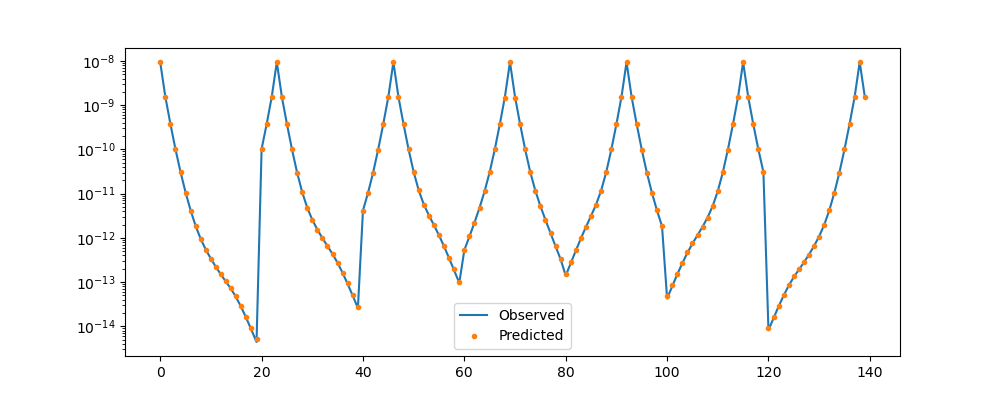

In [26]:
plt.figure(figsize=(10, 4))
#iteration = 16
iteration = len(save.outDict.keys())
plt.semilogy(abs(em_data.dobs), '-', label='Observed')
plt.semilogy(abs(save.outDict[iteration]['dpred']), '.', label='Predicted')
plt.legend()

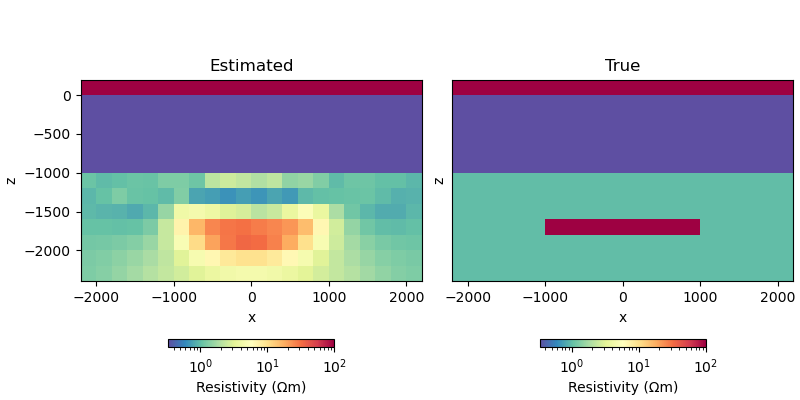

In [30]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)

sigm_est = conductivity_map * save.outDict[iteration]['m']
sigmas = [sigm_est, sigma]
titles = ["Estimated", "True"]
for ii, ax in enumerate(axs):
    out = mesh.plot_slice(
        1./sigmas[ii], grid=False, normal='Y', 
        pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=100)}, 
        ax=ax,
    )
    ax.set_aspect(1)
    if ii == 1:
        ax.set_yticks([])
    ax.set_title(titles[ii])
    cb = plt.colorbar(out[0], ax=ax, fraction=0.03, orientation='horizontal')
    cb.set_label("Resistivity (Ωm)")

In [28]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Wed Aug 14 12:01:38 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC
  12.4.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev20+ge383ae1.d20240809
           empymod : 2.3.1
            xarray : 2024.7.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.5
           IPython : 8.26.0
            simpeg : 0.14.3.dev3195+ge0766b7bb
--------------------------------------------------------------------------------